<a href="https://colab.research.google.com/github/Pablobm3/Detector-de-Balsas/blob/main/pruebaUnet_mejorado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
print(keras.__version__)

2.12.0
2.12.0


In [ ]:
import os
import numpy as np
from PIL import Image
import cv2
from skimage.measure import label, regionprops
import scipy.ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import io,measure

def crear_mascara_mejorada(imagen_path, salida_path):
  """
  Crea una máscara binaria detectando balsas por color y forma geométrica,
  mejorada para incluir balsas más pequeñas y refinar los contornos.

  Args:
      imagen_path (str): Ruta de la imagen original.
      salida_path (str): Ruta para guardar la máscara generada.
  """
  # Cargar imagen
  img = np.array(Image.open(imagen_path))

  hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
  ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)


  maskrgb = cv2.inRange(img,(17, 9, 27), (47, 12, 101))
  maskhsv = cv2.inRange(hsv, (100, 50, 20), (130, 255, 80))
  maskhsv1 = cv2.inRange(hsv, (0,0,0), (255, 255, 30))
  maskycrcb = cv2.inRange(ycrcb, (0, 135, 85), (255, 170, 120))
  maskyrcrcb1 = cv2.inRange(ycrcb, (0, 135, 85), (100, 175, 135))
  maskyrcrcb2 = cv2.inRange(ycrcb, (0, 0, 0), (30, 255, 255))
  mascara_color = cv2.bitwise_or(maskhsv, maskhsv1)
  mascara_color = cv2.bitwise_or(mascara_color, maskrgb)
  mascara_color = cv2.bitwise_or(mascara_color, maskycrcb)
  mascara_color = cv2.bitwise_or(mascara_color, maskyrcrcb1)
  mascara_color = cv2.bitwise_or(mascara_color, maskyrcrcb2)






  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))  # Adjust kernel size
  mascara_morfo = cv2.morphologyEx(mascara_color, cv2.MORPH_OPEN, kernel,iterations=4)
  mascara_morfo = cv2.morphologyEx(mascara_morfo, cv2.MORPH_CLOSE, kernel,iterations=2)

  # Suavizar bordes para contornos más precisos
  mascara_suavizada = cv2.GaussianBlur(mascara_morfo, (5, 5), 0)


    # Encontrar contornos
  contornos, _ = cv2.findContours(mascara_suavizada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  mascara_final = np.zeros_like(mascara_morfo)

      # Filtrar contornos basados en forma y tamaño
  for contorno in contornos:
          # Calcular características del contorno
    area = cv2.contourArea(contorno)
    perimetro = cv2.arcLength(contorno, True)
    x, y, w, h = cv2.boundingRect(contorno)

          # Filtros geométricos
    if area > 0.00000000000001:  # Detectar balsas pequeñas
        relacion_aspecto = w / h if w > h else h / w
        circularidad = (4 * np.pi * area) / (perimetro ** 2) if perimetro > 0 else 0

              # Aceptar contornos rectangulares o cuadrados con baja circularidad
        if 0.000000000001 <= relacion_aspecto <= 10000000.0 and circularidad < 500000:
                    # Agregar contorno a la máscara final
           cv2.drawContours(mascara_final, [contorno], -1, 255, -1)

  # Etiquetar regiones
  labeled_mask = measure.label(mascara_final)

  # Calcular propiedades de las regiones
  regions = regionprops(labeled_mask)

  # Definir umbral de área (ajusta este valor según tus necesidades)
  area_threshold = 6000

  # Filtrar regiones por área
  filtered_regions = [region for region in regions if region.area < area_threshold]

  # Crear nueva máscara
  filtered_mask = np.zeros_like(mascara_final, dtype=bool)
  for region in filtered_regions:
      # Obtener las coordenadas de la región
      minr, minc, maxr, maxc = region.bbox
      # Asignar True a la nueva máscara en las coordenadas de la región
      filtered_mask[minr:maxr, minc:maxc] = region.image


  # Guardar la máscara generada
  Image.fromarray(filtered_mask).save(salida_path)

# Generar máscaras con el nuevo método
directorio_imagenes = "/content/drive/MyDrive/imagenes_balsas/"
nombres_imagenes = [f"Balsa{i}.jpg" for i in range(1, 56)]
salida_mascaras = "/content/drive/MyDrive/imagenes_balsas/Mascaras/"

os.makedirs(salida_mascaras, exist_ok=True)  # Crear directorio si no existe

for nombre in nombres_imagenes:
    crear_mascara_mejorada(
        os.path.join(directorio_imagenes, nombre),
        os.path.join(salida_mascaras, nombre.split('.')[0] + "_mask.jpg")
    )


In [ ]:
import tensorflow as tf

# Import from tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import label

# Rutas
directorio_imagenes = "/content/drive/MyDrive/imagenes_balsas/"
directorio_mascaras = "/content/drive/MyDrive/imagenes_balsas/Mascaras/"
nombres_imagenes = [f"Balsa{i}.jpg" for i in range(1, 56)]
mascaras = [f"Balsa{i}_mask.jpg" for i in range(1, 56)]

# Función para cargar imágenes y máscaras redimensionadas
def cargar_datos_unet(directorio_imagenes, directorio_mascaras, nombres_imagenes, mascaras, size=(128, 128)):
    imagenes = []
    etiquetas = []

    for nombre_imagen, nombre_mascara in zip(nombres_imagenes, mascaras):
        img = Image.open(os.path.join(directorio_imagenes, nombre_imagen)).resize(size)
        mask = Image.open(os.path.join(directorio_mascaras, nombre_mascara)).resize(size)

        imagenes.append(np.array(img) / 255.0)  # Normalizar
        etiquetas.append(np.array(mask) / 255.0)  # Máscara binaria

    return np.array(imagenes), np.expand_dims(np.array(etiquetas), -1)

# Cargar datos redimensionados
imagenes, etiquetas = cargar_datos_unet(directorio_imagenes, directorio_mascaras, nombres_imagenes, mascaras)

# Dividir datos en entrenamiento y validación
imagenes_train, imagenes_val, etiquetas_train, etiquetas_val = train_test_split(
    imagenes, etiquetas, test_size=0.2, random_state=42
)

# Data Augmentation
data_gen_args = dict(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                     shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Combinar generadores de imagen y máscara
train_image_generator = image_datagen.flow(imagenes_train, batch_size=4, seed=42)
train_mask_generator = mask_datagen.flow(etiquetas_train, batch_size=4, seed=42)

# *** Modificación: Crear un Dataset desde los generadores ***
train_dataset = tf.data.Dataset.from_generator(
    lambda: zip(train_image_generator, train_mask_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),  # Formato de las imágenes
        tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32)   # Formato de las máscaras
    )
)

# Prefetch para mejorar el rendimiento
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
# *** Fin de la modificación ***

def unet_mejorado(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Bloque 1
    conv1 = Conv2D(64, 3, padding="same")(inputs)
    conv1 = BatchNormalization()(conv1)  # Normalización
    conv1 = Activation("relu")(conv1)
    conv1 = Conv2D(64, 3, padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Bloque 2
    conv2 = Conv2D(128, 3, padding="same")(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    conv2 = Conv2D(128, 3, padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bloque 3 (Cuello)
    conv3 = Conv2D(256, 3, padding="same")(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    conv3 = Conv2D(256, 3, padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    drop3 = Dropout(0.5)(conv3)  # Evitar sobreajuste

    # Bloque 4 (Decodificación)
    up1 = UpSampling2D(size=(2, 2))(drop3)
    up1 = Concatenate()([up1, conv2])
    conv4 = Conv2D(128, 3, padding="same")(up1)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation("relu")(conv4)
    conv4 = Conv2D(128, 3, padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation("relu")(conv4)

    # Bloque 5 (Decodificación)
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = Concatenate()([up2, conv1])
    conv5 = Conv2D(64, 3, padding="same")(up2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation("relu")(conv5)
    conv5 = Conv2D(64, 3, padding="same")(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation("relu")(conv5)

    # Capa de salida
    outputs = Conv2D(1, 1, activation="sigmoid")(conv5)

    return Model(inputs=[inputs], outputs=[outputs])

# Crear y compilar el modelo
modelo_unet_mejorado = unet_mejorado()
modelo_unet_mejorado.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

# Entrenar modelo
history = modelo_unet_mejorado.fit(train_dataset,  epochs=20, validation_data=(imagenes_val, etiquetas_val), steps_per_epoch=50)



Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 287s 6s/step - accuracy: 0.4173 - loss: 0.8635 - val_accuracy: 0.9934 - val_loss: 0.5364
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 275s 6s/step - accuracy: 0.9797 - loss: 0.3233 - val_accuracy: 0.9935 - val_loss: 0.3649
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 277s 6s/step - accuracy: 0.9867 - loss: 0.2196 - val_accuracy: 0.9935 - val_loss: 0.2523
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 282s 6s/step - accuracy: 0.9862 - loss: 0.1861 - val_accuracy: 0.9935 - val_loss: 0.2213
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.9882 - loss: 0.1624 - val_accuracy: 0.9935 - val_loss: 0.1680
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 287s 6s/step - accuracy: 0.9889 - loss: 0.1420 - val_accuracy: 0.9935 - val_loss: 0.1388
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - accuracy: 0.9891 - loss: 0.1275 - val_accuracy: 0.9935 - val_loss: 0.1291
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.9902 - loss: 0.1229 - val_accuracy: 0.9935 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step


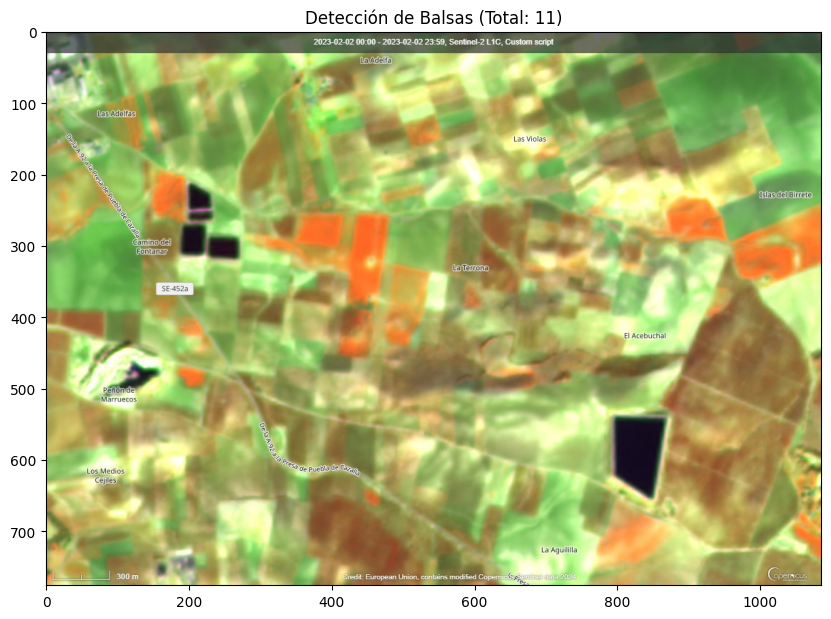

In [ ]:
from tensorflow import keras
from scipy.ndimage import label
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

#modelo_unet_mejorado.save('/content/drive/MyDrive/imagenes_balsas/modelos/modelo_unet_mejorado.keras')
#modelo_unet_mejorado.save('/content/drive/MyDrive/imagenes_balsas/modelos/mi_modelo_unet.h5')

#modelo_cargado = keras.models.load_model('/content/drive/MyDrive/imagenes_balsas/modelos/1.0modelo_unet.keras')

# Función para clasificar una nueva imagen
def clasificar_imagen_unet(imagen_path, modelo, size=(128, 128)):
    img = Image.open(imagen_path).resize(size)
    img_array = np.array(img) / 255.0
    prediccion = modelo.predict(np.expand_dims(img_array, axis=0))
    return prediccion[0, :, :, 0]



# Clasificación de imagen de prueba
imagen_prueba = "/content/drive/MyDrive/imagenes_balsas/Balsa3.jpg"
clasificacion = clasificar_imagen_unet(imagen_prueba, modelo_unet_mejorado)
clasificacion_binaria = (clasificacion > 0.1).astype(np.uint8)


estructura = np.ones((3, 3), dtype=int)
marcado, num_balsas = label(clasificacion_binaria, structure=estructura)

# Obtener dimensiones de la imagen original
imagen_original = Image.open(imagen_prueba)
ancho_original, alto_original = imagen_original.size

# Redimensionar la predicción a las dimensiones originales
clasificacion_redimensionada = cv2.resize(clasificacion_binaria, (ancho_original, alto_original), interpolation=cv2.INTER_NEAREST)

# Encontrar contornos en la predicción redimensionada
contornos, _ = cv2.findContours(clasificacion_redimensionada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Visualización del resultado
plt.figure(figsize=(10, 10))
plt.title(f"Detección de Balsas (Total: {num_balsas})")

# Mostrar la imagen original
plt.imshow(imagen_original)

# Dibujar contornos y bounding boxes en amarillo
for contorno in contornos:
    # Dibujar contorno
    #plt.plot(contorno[:, 0, 0], contorno[:, 0, 1], color='yellow', linewidth=2)

     # Calcular la probabilidad promedio dentro del contorno
    mascara = np.zeros_like(clasificacion_redimensionada, dtype=np.uint8)
    cv2.drawContours(mascara, [contorno], -1, 255, -1)

    # Redimensionar clasificacion para que coincida con la máscara
    clasificacion_resized = cv2.resize(clasificacion, (clasificacion_redimensionada.shape[1], clasificacion_redimensionada.shape[0]))

    probabilidad_promedio = np.mean(clasificacion_resized[mascara == 255])

     # Mostrar solo si la probabilidad es mayor a 0.2 (20%)
    if probabilidad_promedio > 0.3:
          # Dibujar contorno
          plt.plot(contorno[:, 0, 0], contorno[:, 0, 1], color='yellow', linewidth=2)

          # Mostrar la probabilidad como texto
          x, y, w, h = cv2.boundingRect(contorno)
          plt.text(x, y - 10, f"{probabilidad_promedio:.2f}", color='yellow', fontsize=10, fontweight='bold')





plt.show()








In [ ]:
modelo_unet_mejorado.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 5,659,653 (21.59 MB)

 Trainable params: 1,885,697 (7.19 MB)

 Non-trainable params: 2,560 (10.00 KB)

 Optimizer params: 3,771,396 (14.39 MB)

In [ ]:
# Ruta al modelo guardado
ruta_modelo_guardado = "/content/drive/MyDrive/imagenes_balsas/modelos/1.0modelo_unet.keras"  # Reemplaza con la ruta correcta

# Cargar el modelo
otro_modelo = keras.models.load_model(ruta_modelo_guardado)

# Evaluar modelo_unet_mejorado
perdida_modelo1, exactitud_modelo1 = modelo_unet_mejorado.evaluate(imagenes_val, etiquetas_val)

# Evaluar otro_modelo
perdida_modelo2, exactitud_modelo2 = otro_modelo.evaluate(imagenes_val, etiquetas_val)

# Imprimir resultados
print("Modelo U-Net Mejorado - Pérdida:", perdida_modelo1, "Exactitud:", exactitud_modelo1)
print("Otro Modelo - Pérdida:", perdida_modelo2, "Exactitud:", exactitud_modelo2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.9936 - loss: 0.0519
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9912 - loss: 0.0147
Modelo U-Net Mejorado - Pérdida: 0.05193183571100235 Exactitud: 0.9936079382896423
Otro Modelo - Pérdida: 0.014732263050973415 Exactitud: 0.9912109375


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Obtener predicciones
predicciones_modelo1 = modelo_unet_mejorado.predict(imagenes_val)
predicciones_modelo2 = otro_modelo.predict(imagenes_val)

# Calcular métricas (ajusta el umbral según sea necesario)
umbral = 0.5

# *** Modificación: Aplanar y convertir a binario ***
predicciones_binarias_modelo1 = (predicciones_modelo1 > umbral).astype(int).flatten()
predicciones_binarias_modelo2 = (predicciones_modelo2 > umbral).astype(int).flatten()
etiquetas_val_flattened = etiquetas_val.astype(int).flatten()  # Aplanar etiquetas_val
# *** Fin de la modificación ***

precision_modelo1 = precision_score(etiquetas_val_flattened, predicciones_binarias_modelo1) # Usar etiquetas_val_flattened
recall_modelo1 = recall_score(etiquetas_val_flattened, predicciones_binarias_modelo1) # Usar etiquetas_val_flattened
f1_modelo1 = f1_score(etiquetas_val_flattened, predicciones_binarias_modelo1) # Usar etiquetas_val_flattened

precision_modelo2 = precision_score(etiquetas_val_flattened, predicciones_binarias_modelo2) # Usar etiquetas_val_flattened
recall_modelo2 = recall_score(etiquetas_val_flattened, predicciones_binarias_modelo2) # Usar etiquetas_val_flattened
f1_modelo2 = f1_score(etiquetas_val_flattened, predicciones_binarias_modelo2) # Usar etiquetas_val_flattened

# Imprimir resultados
print("Modelo U-Net Mejorado - Precisión:", precision_modelo1, "Recall:", recall_modelo1, "F1-score:", f1_modelo1)
print("Modelo U-Net - Precisión:", precision_modelo2, "Recall:", recall_modelo2, "F1-score:", f1_modelo2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Modelo U-Net Mejorado - Precisión: 0.45454545454545453 Recall: 0.0797872340425532 F1-score: 0.13574660633484162
Modelo U-Net - Precisión: 0.13466550825369245 Recall: 0.824468085106383 F1-score: 0.2315160567587752


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


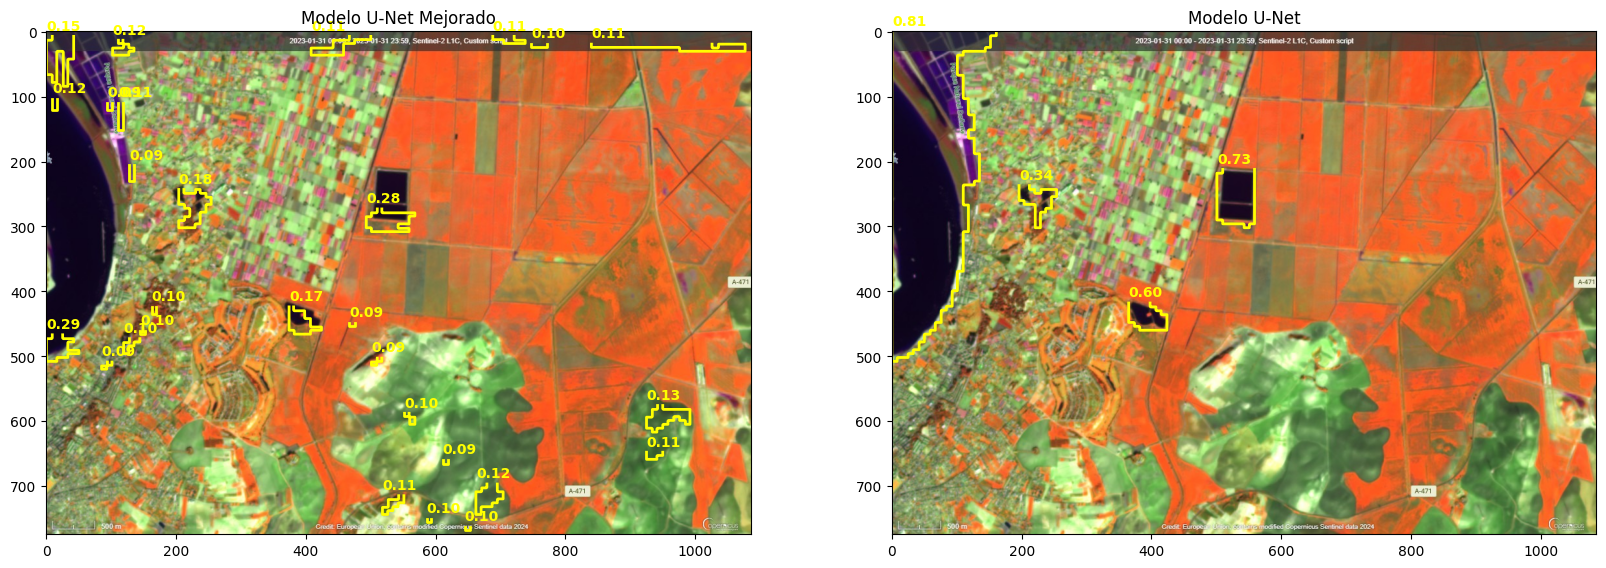

In [ ]:
# Cargar ambos modelos
ruta_modelo_unet_mejorado = "/content/drive/MyDrive/imagenes_balsas/modelos/modelo_unet_mejorado.keras"  # Reemplaza con la ruta correcta
ruta_modelo_unet = "/content/drive/MyDrive/imagenes_balsas/modelos/1.0modelo_unet.keras"  # Reemplaza con la ruta correcta

modelo_unet_mejorado = keras.models.load_model(ruta_modelo_unet_mejorado)
modelo_unet = keras.models.load_model(ruta_modelo_unet)

# Función para clasificar una nueva imagen
def clasificar_imagen_unet(imagen_path, modelo, size=(128, 128)):
    img = Image.open(imagen_path).resize(size)
    img_array = np.array(img) / 255.0
    prediccion = modelo.predict(np.expand_dims(img_array, axis=0))
    return prediccion[0, :, :, 0]

# Clasificación de imagen de prueba con ambos modelos
imagen_prueba = "/content/drive/MyDrive/imagenes_balsas/Balsa8.jpg"

clasificacion_mejorado = clasificar_imagen_unet(imagen_prueba, modelo_unet_mejorado)
clasificacion_unet = clasificar_imagen_unet(imagen_prueba, modelo_unet)

# Convertir a binario (ajusta el umbral si es necesario)
clasificacion_binaria_mejorado = (clasificacion_mejorado > 0.1).astype(np.uint8)
clasificacion_binaria_unet = (clasificacion_unet > 0.1).astype(np.uint8)

# Obtener dimensiones de la imagen original
imagen_original = Image.open(imagen_prueba)
ancho_original, alto_original = imagen_original.size

# Redimensionar las predicciones a las dimensiones originales
clasificacion_redimensionada_mejorado = cv2.resize(clasificacion_binaria_mejorado, (ancho_original, alto_original), interpolation=cv2.INTER_NEAREST)
clasificacion_redimensionada_unet = cv2.resize(clasificacion_binaria_unet, (ancho_original, alto_original), interpolation=cv2.INTER_NEAREST)

# Encontrar contornos en las predicciones redimensionadas
contornos_mejorado, _ = cv2.findContours(clasificacion_redimensionada_mejorado, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contornos_unet, _ = cv2.findContours(clasificacion_redimensionada_unet, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Visualización del resultado para ambos modelos
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Mostrar la imagen original en ambos subplots
axes[0].imshow(imagen_original)
axes[1].imshow(imagen_original)

# Dibujar contornos y bounding boxes para modelo_unet_mejorado en axes[0]
axes[0].set_title("Modelo U-Net Mejorado")
for contorno in contornos_mejorado:
    # Calcular la probabilidad promedio dentro del contorno
    mascara = np.zeros_like(clasificacion_redimensionada_mejorado, dtype=np.uint8)
    cv2.drawContours(mascara, [contorno], -1, 255, -1)
    clasificacion_resized = cv2.resize(clasificacion_mejorado, (clasificacion_redimensionada_mejorado.shape[1], clasificacion_redimensionada_mejorado.shape[0]))
    probabilidad_promedio = np.mean(clasificacion_resized[mascara == 255])

    # Mostrar solo si la probabilidad es mayor a 0.3 (30%)
    if probabilidad_promedio > 0.0:
        axes[0].plot(contorno[:, 0, 0], contorno[:, 0, 1], color='yellow', linewidth=2)
        x, y, w, h = cv2.boundingRect(contorno)
        axes[0].text(x, y - 10, f"{probabilidad_promedio:.2f}", color='yellow', fontsize=10, fontweight='bold')

# Dibujar contornos y bounding boxes para modelo_unet en axes[1]
axes[1].set_title("Modelo U-Net")
for contorno in contornos_unet:
    # Calcular la probabilidad promedio dentro del contorno
    mascara = np.zeros_like(clasificacion_redimensionada_unet, dtype=np.uint8)
    cv2.drawContours(mascara, [contorno], -1, 255, -1)
    clasificacion_resized = cv2.resize(clasificacion_unet, (clasificacion_redimensionada_unet.shape[1], clasificacion_redimensionada_unet.shape[0]))
    probabilidad_promedio = np.mean(clasificacion_resized[mascara == 255])

    # Mostrar solo si la probabilidad es mayor a 0.3 (30%)
    if probabilidad_promedio > 0.3:
        axes[1].plot(contorno[:, 0, 0], contorno[:, 0, 1], color='yellow', linewidth=2)
        x, y, w, h = cv2.boundingRect(contorno)
        axes[1].text(x, y - 10, f"{probabilidad_promedio:.2f}", color='yellow', fontsize=10, fontweight='bold')

plt.show()